<a href="https://colab.research.google.com/github/myazdani/pytorch-deep-learning/blob/master/pytorch_chapter_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chapter 5

In [0]:
import numpy as np
import seaborn as sns;
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [0]:
from IPython.core.debugger import set_trace

In [0]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# Using AutoEncoders for data compression

So far we have covered network that are trained on a pair of inputs $x$ and outputs $y$. Typically the outputs $y$ are something taht we want to predict from $x$. For example, in image classification we want to predict (or label) what the object is for a given input image $x$. The network that we learn will know how to map the input image pixels to a category. In this chapter we are going to train networks that do something much more foundational than just learning a a mapping between an input and output. The networks that we build in this section will learn how the data itself was created!

If that sounds wild, it is. What do we even mean by "how the data was created?" At first this may seem like a completely nonsensical question. We almost always know how the data was created! For example, in the case of images, it is not a mystery how and where the image came from. Consider the image of a cat. We know this image came from a photographer taking a picture of the cat with a camera and perhaps transferring the image to a computer or printing it out. SO when we look at the picture of the cagt on the computer, we know where the image came from . 

But the question we are asking here is much deeper. What is it about the particularr arrangement of the pixels in the iamge that conveys a cat? How is it that the particular arrangement of pixels conveys the image of a cat as opposed to something else? There must be something very special about this particular arrangement of pixels. 

Lets consider a simpler set of images: the MNIST dataset. These are 28-by-28 gray scale images that show handwritten images betwen 0 to 9. In each image there are 28\*28 = 784 pixels total. Since the images are grayscale, each pixel can take values between 0 to 255 or 2^8 distinct values. Given that each pixel can take 2^8 values and that there are 784 pixels total, there can be a grand total of 2^(8\*784) or 2^6272  possible types of images. The total number of atoms in the universe is estimated around 2^246, far fewer than the total number of images that can be expressed with MNIST!  So even though the single image can be one of possibly many, the particular images we encounter are a tiny (very tiny!) subset of all possiblities. If we knew what subset of the data was relevant for us, that make the task of understanding the data much easier. 



As a concrete example, lets say we have a collection of data that is only 2-dimensiona. Unlike MNIST that is 784 dimensional, our toy dataset can be easily visualized in a garph. Here what the data looks like below:



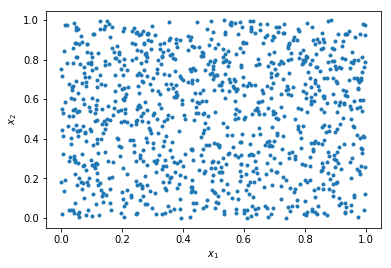

In [0]:
## we will generate the data set using NumPy
x = np.random.rand(1000,2)
plt.plot(x[:,0], x[:,1], '.')
plt.xlabel("$x_1$");
plt.ylabel("$x_2$");

This dataset lacks any concrete structure and appears to be random dots on a 2D plane that lives on your screen (or paper if you have this printed). To describe this dataset  (ie, to represent it), we have no choice but to have a plane. We need two sets of coordinates: and x-axis coordinate and a y-axis. Let's now consider a different dataset (blue dots):

In [0]:
## here we generate another dataset that is not just from a random uniform 
# class Generator(torch.nn.Module):

#     def __init__(self, num_features, num_hidden_1):
#         super(Generator, self).__init__()
        
#         self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
#         self.linear_1_1 = torch.nn.Linear(num_hidden_1, num_hidden_1)
#         self.linear_1_2 = torch.nn.Linear(num_hidden_1, num_hidden_1)
        
#         self.linear_2 = torch.nn.Linear(num_hidden_1, num_features)
        

#     def forward(self, x):
        
#         z = F.relu(self.linear_1(x))
#         z = torch.tanh(self.linear_1_1(z))
#         encoded = self.linear_1_2(z)
#         encoded = torch.tanh(encoded)
        
#         outputs = self.linear_2(encoded)
        
#         return outputs
# torch.manual_seed(42)
# generator = Generator(num_features=1, num_hidden_1 = 30)
    
    


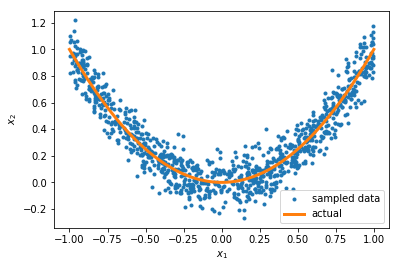

In [0]:
class Generator(torch.nn.Module):
    
    def forward(self, x):            
        return x**2     

    
torch.manual_seed(42)
generator = Generator()

x1 = 1 - 2*torch.rand(1000,1)
x2 = generator(x1)

x2_observed = x2 + .1*torch.randn_like(x1)    

x1_lin = torch.linspace(-1, 1, 1000).view(-1,1)
plt.plot(x1.numpy(), x2_observed.detach().numpy(), '.', label = "sampled data")
plt.plot(x1_lin.numpy(), generator(x1_lin).detach().numpy(), 
         label = "actual", linewidth = 3);
plt.xlabel("$x_1$");
plt.ylabel("$x_2$");
plt.legend();

Though we are still visualizing this dataset on the 2D plane, it has far more structure than the previous dataset. Namely, the data is contrained to be only a specific part of the plane: a warped sort of line. This small space that is occuping the plane we will call the "latent space" or the "hidden space" and denote it as $z$. Unfortunately while the 2D data is given to us and is readily accessible the hidden space, as the name implies, is not given. For 2D data this is not much of an issue as we can from the guide of visualize take some guesses as to what the hidden space is. But in general (for exmample for MNIST that is 784D), visualization cannot help. If we knew about this hidden space, then we can develop algorithms just for the simpler space. Is it possible to design a network that wluld help us discover this latent space? 

This is wherer Auto Encoding Networks or AutoEncoders (AE) come into play. AEs have a particularr structure and loss function that aim at uncovering the latent space. The structure consists of two parrts: an encoder an a decoder. 

The encoder is a fan-in netwokr that consists of one or more layers. Each successive layer projets the dimension of the data to be lower. The output of the encoder is a bottleneck representation that is a much lower dimension than the input. In other words, the output of the encoder is a *compression* of the input. 

This lower dimensional (or bottleneck, or compressed) representation is hopefully a faithful representation of the original high dimensional input and we hypothesize that it corresponds  to the latent space of the input. But how do we know the bottleneck representation is indeed teh latent space if the latent space is hidden from us? 


This is where the decoder network comes in. The decoder network takes the compressed representation and through a series of one or moer layers successively increases the dimension of the data. The dimension is expanded until finallly the output dimension of the decoder is the same as the input dimension of the encoder.  Functionally, what the encoder and decoder networks compute is first compute the latent/encoded representation $z = f_{enc}(x)$, then followed by the decoding $\hat{x} = f_{dec}(z)$ wher $x$ and $\hat{x}$ both have dimension $D$ but $z \in \mathbb{R}^{d}$ with $d \ll D$.

If we have designed (that is, learned) good encoders and decoders, then $\hat{x}$ will be very close to the original $x$. Afterall, if the compression $z$ is worth anything, we should be able to recover the original data. How do we design encoders and decoders that have such desirable properties? We define a loss between $x$ and $\hat{x}$ and using SGD (that is, backprop) find the encoder and decoder network that minimize the loss. 

Let's define training and test datasets and their respective iterators for developing an AutoEncoder

In [0]:

## Define the dataset class as usual
class NoisyQuadraticDataset(Dataset):
    def __init__(self, x):
        self.X = x

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # get data sample
        return self.X[idx,:]
    
# we will use 75% of the data for train and 25% for validation
# since the data sampled was generated IID, we can just take the first 75% for
# the training set and what remains as the validation set
dataset_train = NoisyQuadraticDataset(torch.cat((x1[:750], x2_observed[:750]), 1))
dataset_val = NoisyQuadraticDataset(torch.cat((x1[750:], x2_observed[750:]), 1))

# we will create data loading iteratorrs with a batch size of 4
dataloader_train = DataLoader(dataset_train, batch_size=4, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=4, shuffle=False)    

We will first demonstrate how a purely linear Auto Encoder would perform. If we tie the decoder weights to be the same as the encoder weights, then this is essentially performing PCA. 

In [0]:
class LinearAutoEncoder(torch.nn.Module):

    def __init__(self, num_inputs):
        super(LinearAutoEncoder, self).__init__()
        
        self.linear_1 = torch.nn.Linear(num_inputs, 1)        
        self.linear_2 = torch.nn.Linear(1, num_inputs)
   
    def encoder(self, x):
        z = self.linear_1(x)
        return z
    
    def decoder(self, z):
        x_hat = self.linear_2(z)
        return x_hat
        

    def forward(self, x):
        
        z = self.encoder(x)
        
        x_hat = self.decoder(z)
        
        return x_hat

We define our train and validation methods that we will be using throughout. 

In [0]:
def train(epoch, dataloader, model, criterion, optimizer, device, log_print = 10):
    model.train()
    for i_batch, sample_batched in enumerate(dataloader):
        inputs = sample_batched.to(device)
        
        #set_trace()
        inputs_hat = model(inputs)

        loss = criterion(inputs_hat, inputs)

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        
        if (i_batch%log_print == 0) & (i_batch > 0):
            print('Train batch {0}/{1} Loss: {2}' \
                  .format(i_batch, epoch, loss.item()))
        
        
def validation(epoch, dataloader, model, criterion, device):
    model.eval()
    total_losses = []
    for i_batch, sample_batched in enumerate(dataloader):
        inputs = sample_batched.to(device)

        inputs_hat = model(inputs)

        loss = criterion(inputs_hat, inputs)

        total_losses.append(loss)
    mean_loss = torch.stack(total_losses).mean()
    print('Validation mean Loss: {}'.format(mean_loss.item()))
        

Finally we are ready to instantiate a model, an optimizer, adn define a loss function. Since our datapoints are continous floating points, it makes sense for us to use MSE.  

In [0]:
ae_model = LinearAutoEncoder(2)
optimizer = torch.optim.Adam(ae_model.parameters(), lr=1e-2)
criterion = torch.nn.MSELoss()



We will train for 20 epochs. 

In [0]:
num_epochs = 20
for epoch in range(num_epochs):
    train(epoch, dataloader_train, ae_model, criterion, optimizer, 
          device = "cpu", log_print = np.inf)

    with torch.no_grad():
        validation(epoch, dataloader_val, ae_model, criterion, device = "cpu")


Validation mean Loss: 0.050953421741724014
Validation mean Loss: 0.05230097100138664
Validation mean Loss: 0.05087033286690712
Validation mean Loss: 0.052211929112672806
Validation mean Loss: 0.051714617758989334
Validation mean Loss: 0.05089273676276207
Validation mean Loss: 0.05095979571342468
Validation mean Loss: 0.05030452087521553
Validation mean Loss: 0.050288982689380646
Validation mean Loss: 0.05033589527010918
Validation mean Loss: 0.05334896221756935
Validation mean Loss: 0.052133407443761826
Validation mean Loss: 0.050624310970306396
Validation mean Loss: 0.05157723277807236
Validation mean Loss: 0.05021808296442032
Validation mean Loss: 0.0523744598031044
Validation mean Loss: 0.05079919844865799
Validation mean Loss: 0.05091944336891174
Validation mean Loss: 0.051004063338041306
Validation mean Loss: 0.050556231290102005


After 20 epochs we have converged to an MSE of about 0.51. Let's visualize how this linear Auto Encoder reconstructs the data on the held out set. 

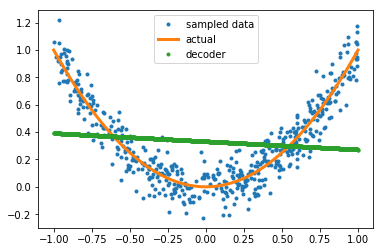

In [0]:
x_lin = torch.linspace(-1, 1, 1000).view(-1,1)
plt.plot(x1.numpy()[:500], x2_observed.detach().numpy()[:500], '.', 
         label = "sampled data")
plt.plot(x_lin.numpy(), generator(x_lin).detach().numpy(), 
         label = "actual", linewidth = 3);

preds = ae_model.decoder(x_lin).squeeze().detach().numpy()

plt.plot(x_lin.numpy(), preds[:,1], '.', 
         label = "decoder", );


plt.legend();

As expected, the Linear Auto Encoder is not able capturer the underlying non-linear manifold that this datasets lives in. 

Let's see how a adding layers of non-linearities will help untangling the non-linear manifold. 

In [0]:
class AutoEncoder(torch.nn.Module):

    def __init__(self, num_inputs, activation_func = lambda x: F.elu(x)):
        super(AutoEncoder, self).__init__()
        
        self.activation_func = activation_func
        self.linear_enc_1 = torch.nn.Linear(num_inputs, num_inputs)              
        self.linear_enc_2 = torch.nn.Linear(num_inputs, 1)        
        
        self.linear_dec_1 = torch.nn.Linear(1, num_inputs)        
        self.linear_dec_2 = torch.nn.Linear(num_inputs, num_inputs)
   
    def encoder(self, x):
        z = self.activation_func(self.linear_enc_1(x))
        z = self.linear_enc_2(z)
        return z
    
    def decoder(self, z):
        z = self.activation_func(self.linear_dec_1(z))
        x_hat = self.linear_dec_2(z)
        return x_hat
        

    def forward(self, x):
        
        z = self.encoder(x)
        
        x_hat = self.decoder(z)
        
        return x_hat

We now instantiate and train our non-linear Auto Encoder:

In [0]:
ae_model = AutoEncoder(2, lambda x: F.tanh(x))
optimizer = torch.optim.Adam(ae_model.parameters(), lr=1e-2)
criterion = torch.nn.MSELoss()
num_epochs = 20
for epoch in range(num_epochs):
    train(epoch, dataloader_train, ae_model, criterion, optimizer, log_print = np.inf,
          device = "cpu")

    with torch.no_grad():
        validation(epoch, dataloader_val, ae_model, criterion, device = "cpu")


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Validation mean Loss: 0.054115742444992065
Validation mean Loss: 0.0382973775267601
Validation mean Loss: 0.016228865832090378
Validation mean Loss: 0.010448736138641834
Validation mean Loss: 0.0063299513421952724
Validation mean Loss: 0.006841366179287434
Validation mean Loss: 0.005340849049389362
Validation mean Loss: 0.005344202741980553
Validation mean Loss: 0.007787058595567942
Validation mean Loss: 0.005022738594561815
Validation mean Loss: 0.005124365910887718
Validation mean Loss: 0.004829417448490858
Validation mean Loss: 0.005091219674795866
Validation mean Loss: 0.005707805044949055
Validation mean Loss: 0.007009535562247038
Validation mean Loss: 0.004949962254613638
Validation mean Loss: 0.005317389499396086
Validation mean Loss: 0.005997296888381243
Validation mean Loss: 0.004971769172698259
Validation mean Loss: 0.004897987004369497


When training the nonlinear Auto Encoder for 20 epochs, we have an MSE that is about 0.005. This is an order magnitude smaller than the loss of the linear Auto Encoder. Visualizing the reconstruction of the points with the non-linear Auto Encoder makes it clear that we have a much better model of capturing the non-linear low dimensional manifold. 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


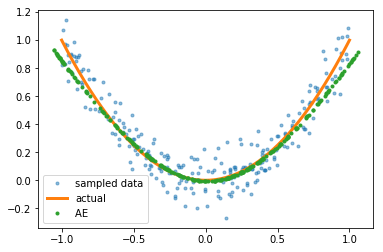

In [0]:
x_lin = torch.linspace(-15, 15, 1000).view(-1,1)
plt.plot(x1.numpy()[750:], x2_observed.detach().numpy()[750:], '.', alpha = .5,
         label = "sampled data")
plt.plot(x1_lin.numpy(), generator(x1_lin).detach().numpy(), 
         label = "actual", linewidth = 3);


preds = ae_model(torch.cat((x1[750:], x2_observed[750:]), 1))
plt.plot(preds[:,0].detach().numpy(), preds[:,1].detach().numpy(), '.', 
         label = "AE ", );

plt.legend();

# Implementing Outlier Detection using AEs

The AE provides us a framework for underrstanding the underlying structure of a dataset. IF we have found the undelying latent space (the particular simple subspace of the data), then we can develop many applications. One such application is outlier detection. In outlier detection we want to find examples of the data that are unsual and unlike the others. 

To demonstrate the idea of outlier detection, we will artificially create some outliers. In practice we do not know which points are outliers, but since we have created them ourselves, we will be able to judge how well our outlier detection algorithm works. 

We will take 50 points (~5% of the data) and randomly shuffle the x2 values. These 50 points then will be our outliers. We will put these 50 corrupted points back into the original dataset and create train and test splits.


In [0]:
X = torch.cat((x1, x2), 1).detach().numpy()

X_corrupt = X[:50]
X_corrupt[:,1] = shuffle(X_corrupt[:,1])

X_uncorrupt = X[50:]

X = np.vstack((X_corrupt, X_uncorrupt))
labels = 50*[1]  + (X.shape[0] - 50)*[0]
X_train, X_test, outlier_train, outlier_test = train_test_split(X, labels,
                                                                shuffle=True, 
                                                                random_state=42)

Plotting the data we can clearly see which points are the outliers. Recall that in practice we do not have the labels for which points are outliers or not. If we did, then we would use supervised learn to directly classify points as either inliers or outliers. 

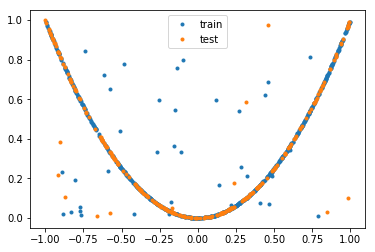

In [0]:
plt.plot(X_train[:,0], X_train[:,1], '.', label = "train")
plt.plot(X_test[:,0], X_test[:,1], '.', label = "test")
plt.legend();

Above we can see a distribution of data points. We can see while the data is in 2D, it occupies a very particular region in the 2D plane. We also see sets of points that are nothing like the distribution of points. These parrticular points we have identified as outliers. We can more formally think of an outlier as points that are *outside* the underlying hidden space. 

So how can we leverage Aes and the latent space to identify outliers? This is an active area of research and there can be many solutions. We will discuss the approach at looking at the reconstructurion erro as an indicator of an outlier. Using the AE framework we know we have idetnified the latent space of a data if we can have low reconstruction error. In other words, after training the encoder and decoder networks in the AE, we know that the output of the AE is recovered input with low reconstruction error on average. 


But what happens if we have the AE receive a point *outside* the latent space? Then in this case the error will be large! Thuss our method of identifying outliers will be if the reconstruction error of an example is *large* then this exmple is suspect of being an outlier. 

Let’s setup our data loaders for training and validation as usual:

In [0]:
dataset_train = NoisyQuadraticDataset(torch.from_numpy(X_train))
dataset_val = NoisyQuadraticDataset(torch.from_numpy(X_test))

dataloader_train = DataLoader(dataset_train, batch_size=4, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=4, shuffle=False)


In [0]:
class AutoEncoder(torch.nn.Module):

    def __init__(self, num_inputs, activation_func = lambda x: F.elu(x)):
        super(AutoEncoder, self).__init__()
        
        self.activation_func = activation_func
        self.linear_enc_1 = torch.nn.Linear(num_inputs, num_inputs)              
        self.linear_enc_2 = torch.nn.Linear(num_inputs, 1)        
        
        self.linear_dec_1 = torch.nn.Linear(1, num_inputs)        
        self.linear_dec_2 = torch.nn.Linear(num_inputs, num_inputs)
   
    def encoder(self, x):
        z = self.activation_func(self.linear_enc_1(x))
        z = self.linear_enc_2(z)
        return z
    
    def decoder(self, z):
        z = self.activation_func(self.linear_dec_1(z))
        x_hat = self.linear_dec_2(z)
        return x_hat
        

    def forward(self, x):
        
        z = self.encoder(x)
        
        x_hat = self.decoder(z)
        
        return x_hat

Instantiate the AE model and train as usual. 

In [0]:

ae_model = AutoEncoder(2, lambda x: F.tanh(x))

optimizer = torch.optim.Adam(ae_model.parameters(), lr=1e-2)
criterion = torch.nn.MSELoss()

num_epochs = 50
for epoch in range(num_epochs):
    train(epoch, dataloader_train, ae_model, criterion, optimizer, "cpu", 
          log_print=np.inf)

    with torch.no_grad():
        validation(epoch, dataloader_val, ae_model, criterion, "cpu")

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Validation mean Loss: 0.027910804376006126
Validation mean Loss: 0.008634479716420174
Validation mean Loss: 0.006566456984728575
Validation mean Loss: 0.006836168933659792
Validation mean Loss: 0.006447928491979837
Validation mean Loss: 0.00574957299977541
Validation mean Loss: 0.006002705544233322
Validation mean Loss: 0.005809234920889139
Validation mean Loss: 0.005433038342744112
Validation mean Loss: 0.005374887026846409
Validation mean Loss: 0.005536112003028393
Validation mean Loss: 0.005562568549066782
Validation mean Loss: 0.005611250642687082
Validation mean Loss: 0.0052709197625517845
Validation mean Loss: 0.006628640461713076
Validation mean Loss: 0.0053482032380998135
Validation mean Loss: 0.005095983389765024
Validation mean Loss: 0.00493639474734664
Validation mean Loss: 0.005350896622985601
Validation mean Loss: 0.007635196670889854
Validation mean Loss: 0.005721825174987316
Validation mean Loss: 0.005556140094995499
Validation mean Loss: 0.004819917492568493
Validation 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


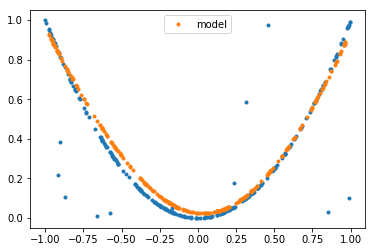

In [0]:
X_test_hat = ae_model(torch.from_numpy(X_test)).detach().cpu().numpy()
plt.plot(X_test[:,0], X_test[:,1], '.')
plt.plot(X_test_hat[:,0], X_test_hat[:,1], '.', label = "model")
plt.legend();

Having trained the model we can see that the model has learned useful representations. 

We now look at the distribution fo reconstruction errors for each individual sample.


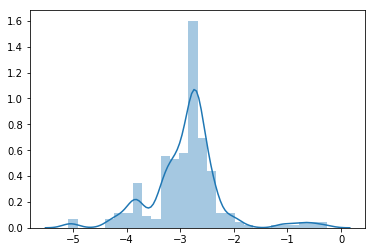

In [0]:
errors = np.sum((X_test - X_test_hat)**2,1)
sns.distplot(np.log10(errors))

We see based on the histogram of reconstruction errors, there are a few samples that have much higher reconstruction errors than others. We may want to consider the points that have very large errors to be outliers.

We will define a threshold that any point that has a reconstruction error higher than this threshold is suspected of being an outlier. Let’s take a look at what these points correspond to. 

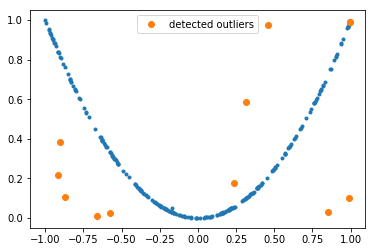

In [0]:
thresh = 10**(-2)
plt.plot(X_test[np.where(errors < thresh)[0],0], 
         X_test[np.where(errors < thresh)[0],1], '.')


plt.plot(X_test[np.where(errors >= thresh)[0],0], 
         X_test[np.where(errors >= thresh)[0],1], 'o',
         label = "detected outliers")
plt.legend();

We see that our threshold has managed to detect some of the outliers. One of the detected outliers is a False Positive but it is interesting to note that this False Positive is from subspace of the data that we have fewer samples from (ie, we are in the tails in the distribution). In general, since we have less points in these regions the network has not been trained as well as the other parts. This gives us another interoperation of large reconstruction errors: these are regions in the space that the network has less confidence in making estimates. 


# Using AEs for Pre-training

As discussed, if we understand the underlying structure of a datset, then we have greatly reduced the complexity of the data. Having reduced the complexity, then developing algorithm should become much easier. Heer is where we can potentially leverrage AEs to aid us sdevelop supervised learning algorithms. 

Recall that developing supervised learning algorithms require a pair of inputs $x$ and outputs/labels $y$. Often obtaining outputs $y$ can be very expensive. Consider for example again the MNIST digits dataset. Each 28-by-28 pixel image was looked at by a human to be assigned a label between 0 and 9. Given that there are over 60K images, labelling each one can take a long time and require a great deal of effort. 

The expensive cost of obtaining labled datasets motivates us to develop learning algorithms that do not require large labelled datasets. What is neat about AEs is that they do not require any labels. All we need is a large collection of unlablled data and this is often much easier and cheaper to obtain.  By training the AE, we have a mapping that takes the original data $x$ and maps to the latent space $z$. From there we can train supervised learning algorithms to predict $y$ from $z$ instead of $x$. 

Why would it be favorable to predcit $y$ frrom $z$ instead of $x$ ? As we discussed earlier, the latent space $z$ is much simpler than the input space $x$. Therefore, by training supervised algorithms in $z$ we hope that the simplicity of the space will require far fewer labeled samples than having labeled samples for $x$. 


So if we are faced in a situation where we have a lot of unlabeled data $x$ and very few labeled data $y$, then it is favorable tl train an AE to map the data frrom $x$ to $z$ and then applying supervised learning in the latent space. More formally, training an AE provides us with an encoder $z = f_{enc}(x)$. What we can do train supervised learning then is develop $y = g(z)$. We can also fine-tune the encoder so that we have in the end $y = g\big(f_{enc}(x)\big)$.

We will demonstrate pre-training a network using the MNIST digits dataset. The `torchvision` module includes APIs to access and load the data.

In [0]:
from torchvision import datasets
from torchvision import transforms

In [0]:


# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())

batch_size = 32
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=False) # setting shuffle to false so we just go on same batch

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 13190295.07it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 296827.72it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 4827712.55it/s]                           
8192it [00:00, 124019.54it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


We will train a simple 1-hidden layer Auto Encoder with fully connected layers. The 

In [0]:
class MLPAutoencoder(torch.nn.Module):

    def __init__(self, num_inputs, num_hidden):
        super(MLPAutoencoder, self).__init__()
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        
        self.linear_1 = torch.nn.Linear(num_inputs, num_hidden)
        
        self.linear_2 = torch.nn.Linear(num_hidden, num_inputs)
        
        
    def encoder(self, x):
        z = self.linear_1(x)
        z = F.leaky_relu(z)
        
        return z
                
    
    def decoder(self, z):
        x_hat = self.linear_2(z)
        
        return torch.sigmoid(x_hat)
        

    def forward(self, x):
        
        z = self.encoder(x)
        x_hat = self.decoder(z)
        
        return x_hat

In [0]:
def unsupervised_train(epoch, dataloader, model, criterion, optimizer, device, 
                       log_print = 10):
    model.train()
    for i_batch, sample_batched in enumerate(dataloader):
        if i_batch > 1:
            break
        inputs = sample_batched[0].view(batch_size,-1).to(device)
        
        #set_trace()
        inputs_hat = model(inputs)

        loss = criterion(inputs_hat, inputs)

        optimizer.zero_grad()
        #loss.backward(retain_graph=True)
        loss.backward()
        optimizer.step()
        
        if (i_batch%log_print == 0) & (i_batch > 0):
            print('Train batch {0}/{1} Loss: {2}' \
                  .format(i_batch, epoch, loss.item()))
    #return loss.item()
    return model
        
        
def unsupervised_validation(epoch, dataloader, model, criterion, device):
    model.eval()
    total_losses = []
    for i_batch, sample_batched in enumerate(dataloader):
        inputs = sample_batched[0].view(batch_size,-1).to(device).to(device)

        inputs_hat = model(inputs)

        loss = criterion(inputs_hat, inputs)

        total_losses.append(loss)
    mean_loss = torch.stack(total_losses).mean()
    print('Validation mean Loss: {}'.format(mean_loss.item()))
    return mean_loss.item()
        

**instantiations**

In [0]:
torch.manual_seed(111)



# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
unsupervised_model = MLPAutoencoder(num_inputs=784, num_hidden=32).to(device)

criterion = torch.nn.BCELoss()

optimizer = torch.optim.Adam(unsupervised_model.parameters(), lr=1e-3)


In [0]:
unsupervised_model.linear_1.weight[:4,:4]

tensor([[ 0.0154,  0.0296, -0.0156, -0.0173],
        [-0.0211, -0.0353,  0.0122,  0.0083],
        [-0.0225, -0.0310, -0.0196, -0.0120],
        [ 0.0235,  0.0284, -0.0338, -0.0213]], device='cuda:0',
       grad_fn=<SliceBackward>)

In [0]:
num_epochs = 5
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    train_losses.append(unsupervised_train(epoch=1, dataloader=train_loader, 
                                           model=unsupervised_model,
                                           criterion=criterion, 
                                           optimizer=optimizer,
                                           device=device,
                                           log_print=np.inf))

In [0]:
train_losses[-1].linear_1.weight[:4,:4]

tensor([[ 0.0154,  0.0296, -0.0156, -0.0173],
        [-0.0211, -0.0353,  0.0122,  0.0083],
        [-0.0225, -0.0310, -0.0196, -0.0120],
        [ 0.0235,  0.0284, -0.0338, -0.0213]], device='cuda:0',
       grad_fn=<SliceBackward>)

In [0]:
unsupervised_model.linear_1.weight[:4,:4]

tensor([[ 0.0154,  0.0296, -0.0156, -0.0173],
        [-0.0211, -0.0353,  0.0122,  0.0083],
        [-0.0225, -0.0310, -0.0196, -0.0120],
        [ 0.0235,  0.0284, -0.0338, -0.0213]], device='cuda:0',
       grad_fn=<SliceBackward>)

In [0]:
unsupervised_model.linear_1.weight[:4,:4].clone()

tensor([[ 0.0154,  0.0296, -0.0156, -0.0173],
        [-0.0211, -0.0353,  0.0122,  0.0083],
        [-0.0225, -0.0310, -0.0196, -0.0120],
        [ 0.0235,  0.0284, -0.0338, -0.0213]], device='cuda:0',
       grad_fn=<CloneBackward>)

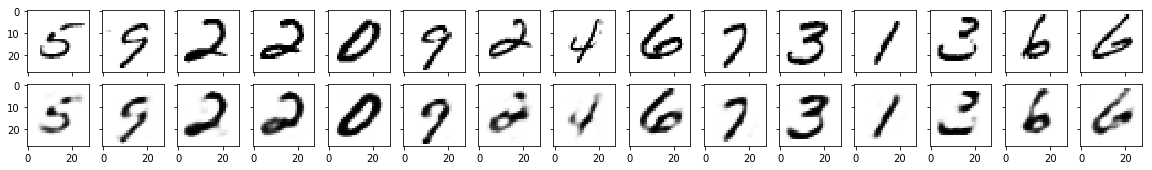

In [0]:
# ##########################
# ### VISUALIZATION
# ##########################

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')

In [0]:
##########################
### MODEL
##########################

class MLPPreTrained(torch.nn.Module):

    def __init__(self, num_hidden = 128):
        super(MLPPreTrained, self).__init__()
        
        ### ENCODER
        self.linear_1 = torch.nn.Linear(784, 32)

        
        self.linear_2 = torch.nn.Linear(32, num_hidden)
        
        self.linear_3 = torch.nn.Linear(num_hidden, 10)
        
        self.softmax = torch.nn.Softmax(dim=1)
        

    def forward(self, x):
        
        z = F.leaky_relu(self.linear_1(x))
        
        z = F.leaky_relu(self.linear_2(z))
        
        z = self.linear_3(z)
        return self.softmax(z)

In [0]:
import copy

In [0]:
torch.manual_seed(111)
supervised_model = MLPPreTrained(128).to("cuda")

In [0]:

supervised_model.linear_1.weight[:4,:4]

tensor([[ 0.0154,  0.0296, -0.0156, -0.0173],
        [-0.0211, -0.0353,  0.0122,  0.0083],
        [-0.0225, -0.0310, -0.0196, -0.0120],
        [ 0.0235,  0.0284, -0.0338, -0.0213]], device='cuda:0',
       grad_fn=<SliceBackward>)

In [0]:

supervised_model.linear_1.weight = copy.deepcopy(unsupervised_model.linear_1.weight)
supervised_model.linear_1.bias = copy.deepcopy(unsupervised_model.linear_1.bias)
optimizer = torch.optim.SGD(supervised_model.parameters(), lr=1e-1, momentum = .9)

In [0]:
unsupervised_model.linear_1.weight[:4,:4]

tensor([[ 0.0154,  0.0296, -0.0156, -0.0173],
        [-0.0211, -0.0353,  0.0122,  0.0083],
        [-0.0225, -0.0310, -0.0196, -0.0120],
        [ 0.0235,  0.0284, -0.0338, -0.0213]], device='cuda:0',
       grad_fn=<SliceBackward>)

In [0]:
criterion = torch.nn.CrossEntropyLoss()

In [0]:
device = "cuda"
num_epochs = 2000
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        if batch_idx > 0:
            break
        
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        supervised_model.train()
        preds = supervised_model(features)
        loss = criterion(preds, targets.to(device))
        optimizer.zero_grad()
        
        loss.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        train_losses.append(np.mean(targets.detach().cpu().numpy() == 
                            torch.argmax(preds,1).detach().cpu().numpy()))
        
    supervised_model.eval()
    features = features.view(-1, 28*28).to(device)
            
    preds = supervised_model(features)

    test_losses.append(np.mean(targets.detach().cpu().numpy() == 
                               torch.argmax(preds,1).detach().cpu().numpy()))
    
        

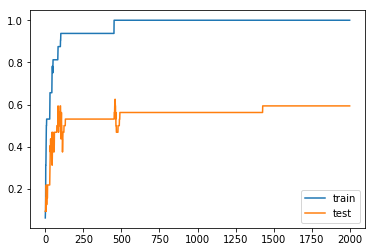

In [0]:
plt.plot(train_losses, label = "train")
plt.plot(test_losses, label = "test")
plt.legend();

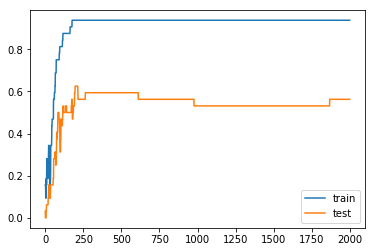

In [0]:
plt.plot(train_losses, label = "train")
plt.plot(test_losses, label = "test")
plt.legend();

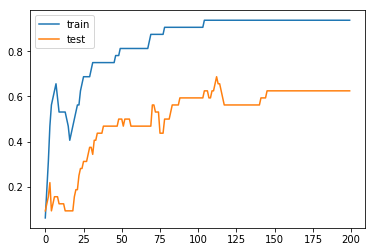

In [0]:
plt.plot(train_losses, label = "train")
plt.plot(test_losses, label = "test")
plt.legend();

In [0]:
batch_idx

0

In [0]:
##########################
### MODEL
##########################

class MLP(torch.nn.Module):

    def __init__(self, num_hidden = 128):
        super(MLP, self).__init__()
        
        ### ENCODER
        self.linear_1 = torch.nn.Linear(784, 1024)

        
        self.linear_2 = torch.nn.Linear(1024, 10)
       
        
        self.softmax = torch.nn.Softmax(dim=1)
        

    def forward(self, x):
        
        z = F.leaky_relu(self.linear_1(x))
        
        
        z = self.linear_2(z)
        return self.softmax(z)

In [0]:
torch.manual_seed(random_seed)
baseline_model = MLPPreTrained(256).to(device)
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=learning_rate)

In [0]:
criterion = torch.nn.CrossEntropyLoss()

In [0]:
num_epochs = 200
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        if batch_idx > 0:
            break
        
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        baseline_model.train()
        preds = baseline_model(features)
        loss = criterion(preds, targets)
        optimizer.zero_grad()
        
        loss.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        train_losses.append(np.mean(targets.detach().numpy() == 
                            torch.argmax(preds,1).detach().numpy()))
        
    baseline_model.eval()
    features = features.view(-1, 28*28).to(device)
            
    preds = baseline_model(features)

    test_losses.append(np.mean(targets.detach().numpy() == 
                               torch.argmax(preds,1).detach().numpy()))
    
        

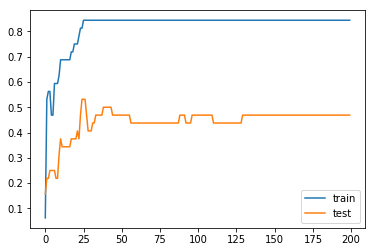

In [0]:
plt.plot(train_losses, label = "train")
plt.plot(test_losses, label = "test")
plt.legend();

# Implementing Denoising AE

Training AEs provides us with a framework for uncovering the hidden/latent space of a dataset. The advantage of uncovering this latent space is that it is far simpler than the original space. As suggested in the outlier detection section, if the data points deviate from the latent space, then they will hav a very different properties than the rest of the data. This observation leads us to an application of AEs for de-noising noisy data. The denoising AE is a training framework for recoving clearn data from noise-corrupted data. 


Here is how it works. In the usual AE, the input to the AE is $x$ and the output is $\hat{x}$. We train the AE so that the loss between $x$ and $\hat{x}$ is small. That is, we want to make sure that the AE is able to recoover the input data. In the denoisinng AE,during training the input $x$ is purposefully corrupted with noise so that the input is $x_{\text{corrupted}}$. The output of the AE $\hat{x}$ then is to recover the original uncorrupted $x$. 

The neat part is is since we actually have the original uncorrupted $x$ we are able to compute the loss $l(x, \hat{x})$, that is we want the output to recover no thet corrupted input but the original uncorrupted $x$. 



For example, lets say we wanted to solve the problem where some pixles an image corrupted (eg. mssing) etc. 

# Using Siamese Networks for Pre-Training


In some applications we are not interested in predicting an output $y$ for a given input $x$ but rather want to know how one input $x_{i}$ compares to another $x_j$. For example, lets imagine we want to build a security camera system that allows entry to a building only for people on a "Green List." The way this would worrk is we have a list of pictures of individuals in our system that we place on the Green List that we would allow in to the building. Then when an idividual approaches the entry of the building, the security camera takes a picture and compares this picture with the list of pictures in the Green List. If there is a match to our Green List, then we allow entry. 

How can we go about building such a system? A first naive approach would be to compute the distance between the query image and the set of Green Listed images. If we have $N$ images in our Green List, then we compute $N$ distances. If the smallet distance is below some threshold $T$ then we accept the query image as being part of the Green List and otherwise reject. 

In practice we have to be very careful how we design the distance function. Unfortunately a simple Euclidean distance between the pixels is terrible. A much better approach would be to extract features from the image and we compute distance over the image features instead of the pixels. How would we go about extracting features? Well, we know that th efeatures we get froma pre-trained network re very useful. So we could use that and have a baseline system. 

One drawback of our approach is that we are not doing any learning or fine-tuning the system. This is where the Siamese Network can be a useful framework. In this framework we train a network over pairs of samples and each pair is assigned a label. For example, a query image and another image are assigned a label if they are showing the same person. Because the Network is over pairs of inputs, it has a pecuiliar architecture. 

We have a single embedding network $f_{emb}$ that acts twice on the a pair of inputs $x_{i}$ and $x_{j}$ to produce $z_i = f_{emb}(x_i)$ and $z_j = f_{emb}(x_j)$. Note that even though we have two inputs and two outputs, there is only *one* network. Sometimes this is referred to as having a two networks for each input but with "tied" or "shared" weights. Then the distance between $z_i$ and $z_j$ will determine if the two samples are similar or not. 




In [0]:
from torch.utils.data import Dataset
from PIL import Image

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:

# provided courtesy of: https://github.com/adambielski/siamese-triplet
class SiameseMNIST(Dataset):
    """
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}
        else:
            # generate fixed pairs for testing
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                               1]
                              for i in range(0, len(self.test_data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.test_labels[i].item()]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.test_data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        if self.train:
            target = np.random.randint(0, 2)
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            if target == 1:
                siamese_index = index
                while siamese_index == index:
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else:
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.train_data[siamese_index]
        else:
            img1 = self.test_data[self.test_pairs[index][0]]
            img2 = self.test_data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]

        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return (img1, img2), target

    def __len__(self):
        return len(self.mnist_dataset)

In [0]:
from torchvision.datasets import MNIST
from torchvision import transforms

mean, std = 0.1307, 0.3081

train_dataset = MNIST('../data/MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = MNIST('../data/MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
n_classes = 10

0it [00:00, ?it/s]

9920512it [00:01, 6759732.76it/s]                             


Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 309296.41it/s]                           
0it [00:00, ?it/s]

Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 4977643.74it/s]                           
8192it [00:00, 123440.77it/s]


Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [0]:
siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [0]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, 2)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)

In [0]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)


In [0]:
embedding_model = EmbeddingNet()
siamese_model = SiameseNet(embedding_net = embedding_model)

In [0]:
siamese_model = SiameseNet(embedding_net = EmbeddingNet())
if cuda:
    siamese_model.cuda()

In [0]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()
    
    
def train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics):
    for metric in metrics:
        metric.reset()

    model.train()
    losses = []
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        if cuda:
            data = tuple(d.cuda() for d in data)
            if target is not None:
                target = target.cuda()


        optimizer.zero_grad()
        outputs = model(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        for metric in metrics:
            metric(outputs, target, loss_outputs)

        if batch_idx % log_interval == 0:
            message = 'Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses))
            for metric in metrics:
                message += '\t{}: {}'.format(metric.name(), metric.value())

            print(message)
            losses = []

    total_loss /= (batch_idx + 1)
    return total_loss, metrics
    
    
def test_epoch(val_loader, model, loss_fn, cuda, metrics):
    with torch.no_grad():
        for metric in metrics:
            metric.reset()
        model.eval()
        val_loss = 0
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            if cuda:
                data = tuple(d.cuda() for d in data)
                if target is not None:
                    target = target.cuda()

            outputs = model(*data)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            val_loss += loss.item()

            for metric in metrics:
                metric(outputs, target, loss_outputs)

    return val_loss, metrics    

In [0]:
loss_fn = ContrastiveLoss(1.1)
optimizer = torch.optim.Adam(siamese_model.parameters(), lr=1e-3)

In [0]:
n_epochs = 30
metrics = []
log_interval = 100
for epoch in range(n_epochs):

    # Train stage
    train_loss, metrics = train_epoch(siamese_train_loader, siamese_model, loss_fn, optimizer, cuda, log_interval, metrics)

    message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)
    for metric in metrics:
        message += '\t{}: {}'.format(metric.name(), metric.value())

    val_loss, metrics = test_epoch(siamese_test_loader, siamese_model, loss_fn, cuda, metrics)
    val_loss /= len(siamese_test_loader)

    message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs,
                                                                             val_loss)
    for metric in metrics:
        message += '\t{}: {}'.format(metric.name(), metric.value())

Train: [0/60000 (0%)]	Loss: 0.019091
Train: [12800/60000 (21%)]	Loss: 0.022808
Train: [25600/60000 (43%)]	Loss: 0.019412
Train: [38400/60000 (64%)]	Loss: 0.016562
Train: [51200/60000 (85%)]	Loss: 0.014033
Train: [0/60000 (0%)]	Loss: 0.010193
Train: [12800/60000 (21%)]	Loss: 0.013609
Train: [25600/60000 (43%)]	Loss: 0.010862
Train: [38400/60000 (64%)]	Loss: 0.010752
Train: [51200/60000 (85%)]	Loss: 0.010837
Train: [0/60000 (0%)]	Loss: 0.016271
Train: [12800/60000 (21%)]	Loss: 0.009746
Train: [25600/60000 (43%)]	Loss: 0.008306
Train: [38400/60000 (64%)]	Loss: 0.007555
Train: [51200/60000 (85%)]	Loss: 0.008958
Train: [0/60000 (0%)]	Loss: 0.015597
Train: [12800/60000 (21%)]	Loss: 0.006119
Train: [25600/60000 (43%)]	Loss: 0.005288
Train: [38400/60000 (64%)]	Loss: 0.005099
Train: [51200/60000 (85%)]	Loss: 0.004936
Train: [0/60000 (0%)]	Loss: 0.004123
Train: [12800/60000 (21%)]	Loss: 0.004543
Train: [25600/60000 (43%)]	Loss: 0.004763
Train: [38400/60000 (64%)]	Loss: 0.004334
Train: [51200/600

In [0]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

In [0]:
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

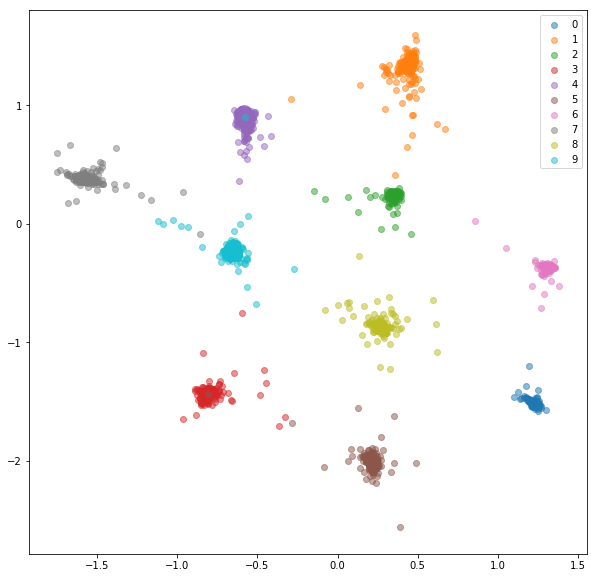

In [0]:

train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, siamese_model)
plot_embeddings(train_embeddings_cl, train_labels_cl)

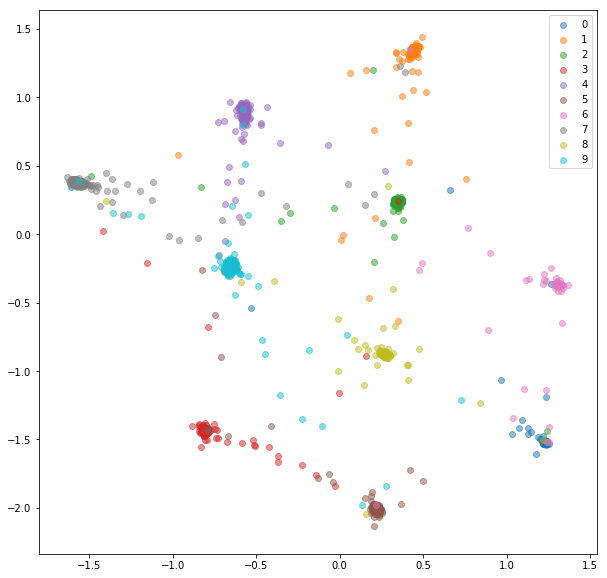

In [0]:
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, siamese_model)
plot_embeddings(val_embeddings_cl, val_labels_cl)